In [ ]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    adjusted_rand_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

from customer_segmentation.utils import file_io, preprocessing, plot_utils

modules_to_reload = [file_io, preprocessing, plot_utils]
for module in modules_to_reload:
    importlib.reload(module)

# Set pandas to display all columns
pd.set_option("display.max_columns", None)

In [ ]:
cohort = file_io.read_or_write_csv(file_name="cohort_data.csv", to_read=True)

### **Preprocessing**

In [ ]:
# convert data & seperate binary and numeric values

cohort["user_id"] = cohort["user_id"].astype(str)
# get binary and numeric values
binary_cols = preprocessing.get_binary_columns(cohort)
numeric_cols = cohort.select_dtypes(include=[np.number]).columns.to_list()

**Select features for scaling & PCA**

In [39]:
feature_groups = {
    # Split discounts
    "flight_discount_score": [
        "avg_flight_discount",
        "flight_discount_rate",
        "discount_per_km",
    ],
    "hotel_discount_score": [
        "avg_hotel_discount",
        "hotel_discount_rate",
    ],
    # User demographics
    "user_score": ["age", "is_married", "has_children"],
    # Engagement
    "engagement_score": [
        "days_last_trip",
        "sessions_per_month",
        "avg_session_duration_seconds",
        "page_click_per_session",
    ],
    # Travel features split
    "flight_travel_score": [
        "avg_flight_travel_days",
        "avg_seats",
        "avg_checked_bags",
        "avg_distance_km",
        "flight_booked",
        "flight_booking_value",
    ],
    "hotel_travel_score": [
        "avg_rooms",
        "avg_hotel_nights",
        "hotel_booked",
        "hotel_booking_value",
    ],
    # Cancellations
    "cancellation_score": ["cancellation_rate"],
}

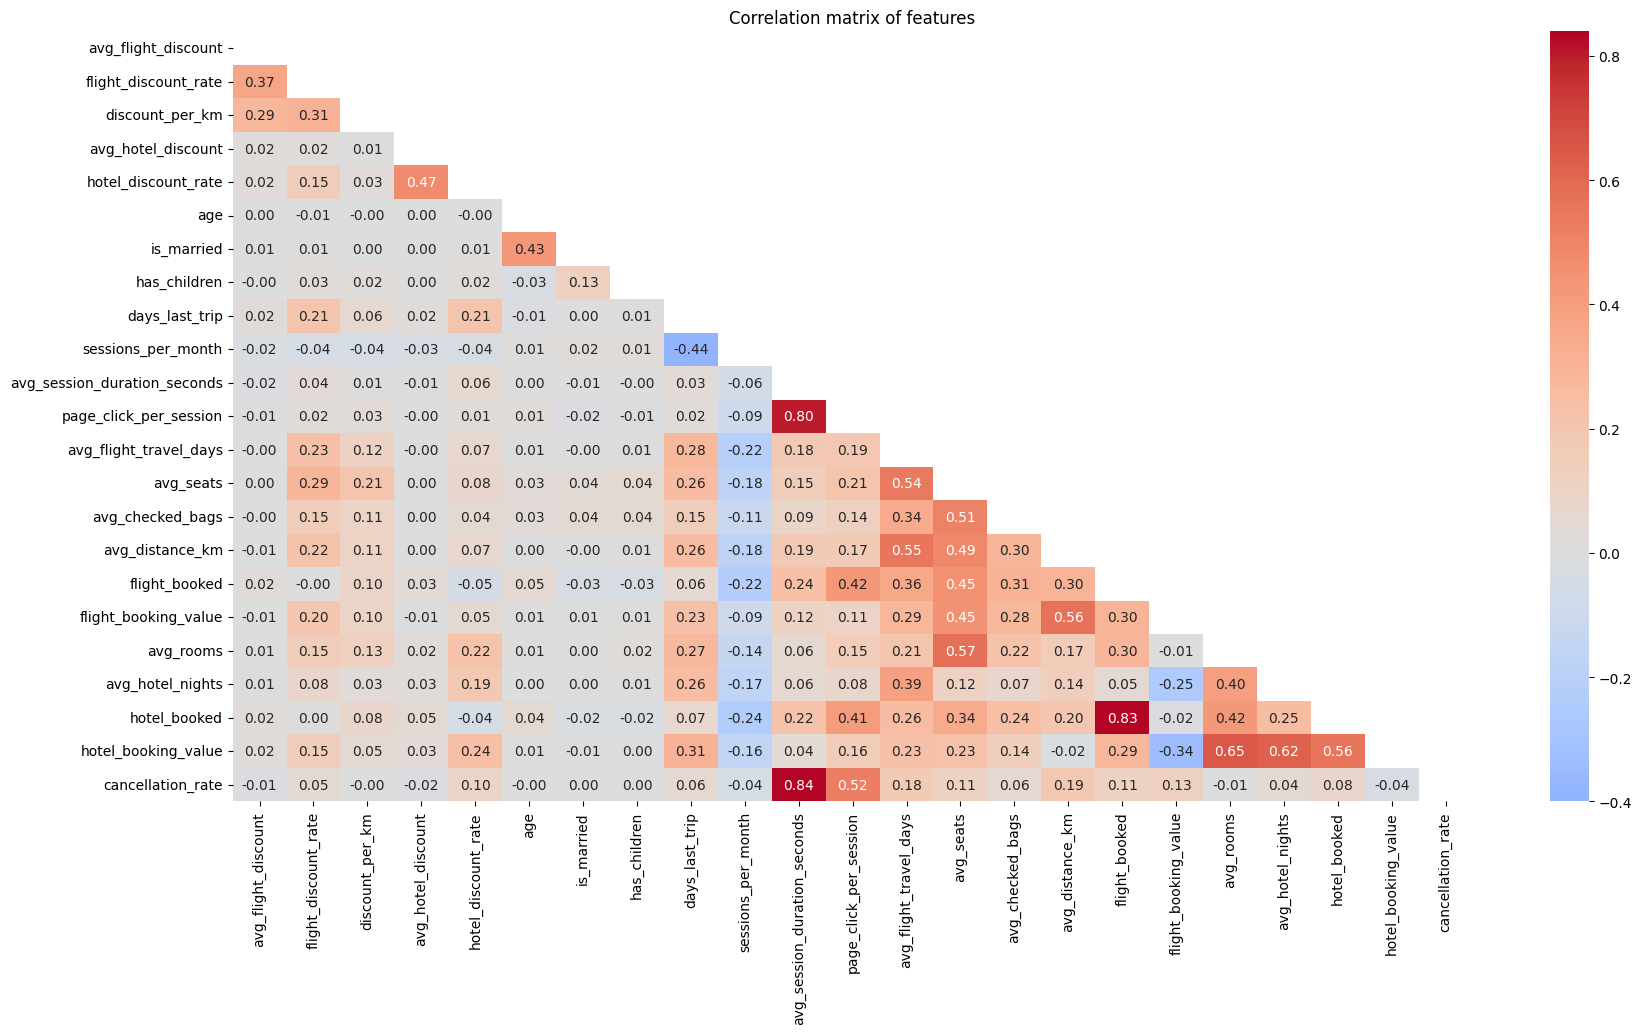

In [40]:
metrics = [m for _, metric in feature_groups.items() for m in metric]

matrix = np.triu(cohort[metrics].corr())
plt.figure(figsize=(20, 10))
plt.title("Correlation matrix of features", fontsize=12)
sns.heatmap(
    cohort[metrics].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-0.4,
    center=0,
    mask=matrix,
)
plt.show()

**Apply PCA per thematic groups**

In [ ]:
for score_name, features in feature_groups.items():
    cohort = preprocessing.PCA_pipeline(df=cohort, features=features, score_name=score_name)

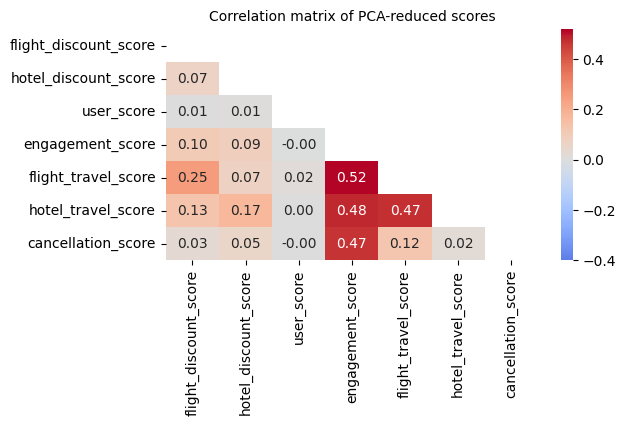

In [42]:
scores = [k for k in feature_groups.keys()]

matrix = np.triu(cohort[scores].corr())
plt.figure(figsize=(6, 3))
plt.title("Correlation matrix of PCA-reduced scores", fontsize=10)
sns.heatmap(
    cohort[scores].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-0.4,
    center=0,
    mask=matrix,
)
plt.show()

### **Clustering**

**Extract scores for clustering**

In [43]:
X = cohort[scores]

**Apply elbow-method to find k number of cluster**

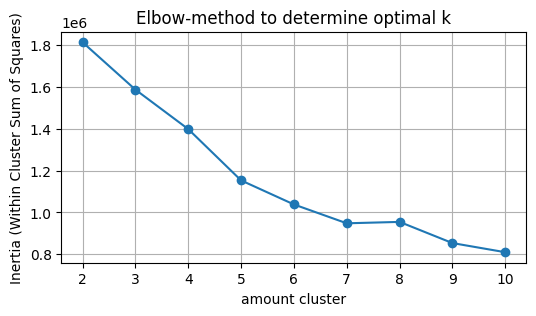

In [44]:
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=3, n_init="auto")
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6, 3))
plt.plot(k_range, inertia, "o-")
plt.xlabel("amount cluster")
plt.ylabel("Inertia (Within Cluster Sum of Squares)")
plt.title("Elbow-method to determine optimal k")
plt.grid(True)
plt.show()

**Apply kmeans clustering**

In [45]:
kmeans = KMeans(n_clusters=6, random_state=3, n_init="auto")
cohort["kmeans_cluster"] = kmeans.fit_predict(X)

In [ ]:
# mean values per cluster
cluster_profiles = cohort.groupby("kmeans_cluster")[scores].mean().round(2).T

cluster_profiles.style.background_gradient(cmap="YlGnBu").format(
    "{:.2f}"
).set_properties(**{"font-size": "12px", "padding": "10px"})

![kmeans-cluster-table](../images/kmeans_cluster_table.png?v2)

**GGM clustering**

In [47]:
gmm = GaussianMixture(n_components=6, random_state=3)
cohort["gmm_cluster"] = gmm.fit_predict(X)

In [ ]:
# mean values per cluster
cluster_profiles = cohort.groupby("gmm_cluster")[scores].mean().round(2).T

cluster_profiles.style.background_gradient(cmap="YlGnBu").format(
    "{:.2f}"
).set_properties(**{"font-size": "12px", "padding": "10px"})

![gmm cluster table](../images/gmm_cluster_table.png?v2)

### **Compare cluster models**

In [49]:
# Adjusted Rand Index (ARI) measures the similarity of two cluster assignments

ari = adjusted_rand_score(cohort["kmeans_cluster"], cohort["gmm_cluster"])
print(f"Adjusted Rand Index: {ari:.2f}")

Adjusted Rand Index: 0.58


In [50]:
# validate KMeans
labels_kmeans = cohort["kmeans_cluster"]
db_kmeans = davies_bouldin_score(X, labels_kmeans)
ch_kmeans = calinski_harabasz_score(X, labels_kmeans)

print("KMeans - Davies-Bouldin:", round(db_kmeans, 2))
print("KMeans - Calinski-Harabasz:", round(ch_kmeans, 2))

# validate Gaussian Mixture Model
labels_gmm = cohort["gmm_cluster"]
db_gmm = davies_bouldin_score(X, labels_gmm)
ch_gmm = calinski_harabasz_score(X, labels_gmm)

print("GMM - Davies-Bouldin:", round(db_gmm, 2))
print("GMM - Calinski-Harabasz:", round(ch_gmm, 2))

KMeans - Davies-Bouldin: 1.31
KMeans - Calinski-Harabasz: 61053.58
GMM - Davies-Bouldin: 1.35
GMM - Calinski-Harabasz: 57698.47


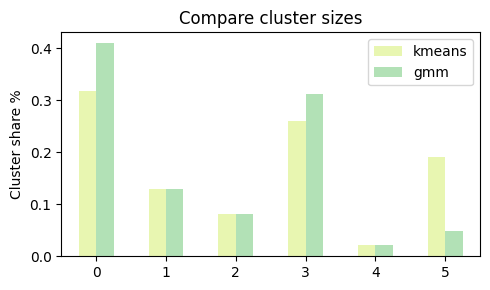

In [51]:
cluster_sizes = pd.DataFrame(
    {
        "kmeans": cohort["kmeans_cluster"].value_counts(normalize=True),
        "gmm": cohort["gmm_cluster"].value_counts(normalize=True),
    }
)
cluster_sizes.plot(kind="bar", color=sns.color_palette("YlGnBu"), figsize=(5, 3))
plt.title("Compare cluster sizes")
plt.xticks(rotation=0)
plt.ylabel("Cluster share %")
plt.tight_layout()
plt.show()

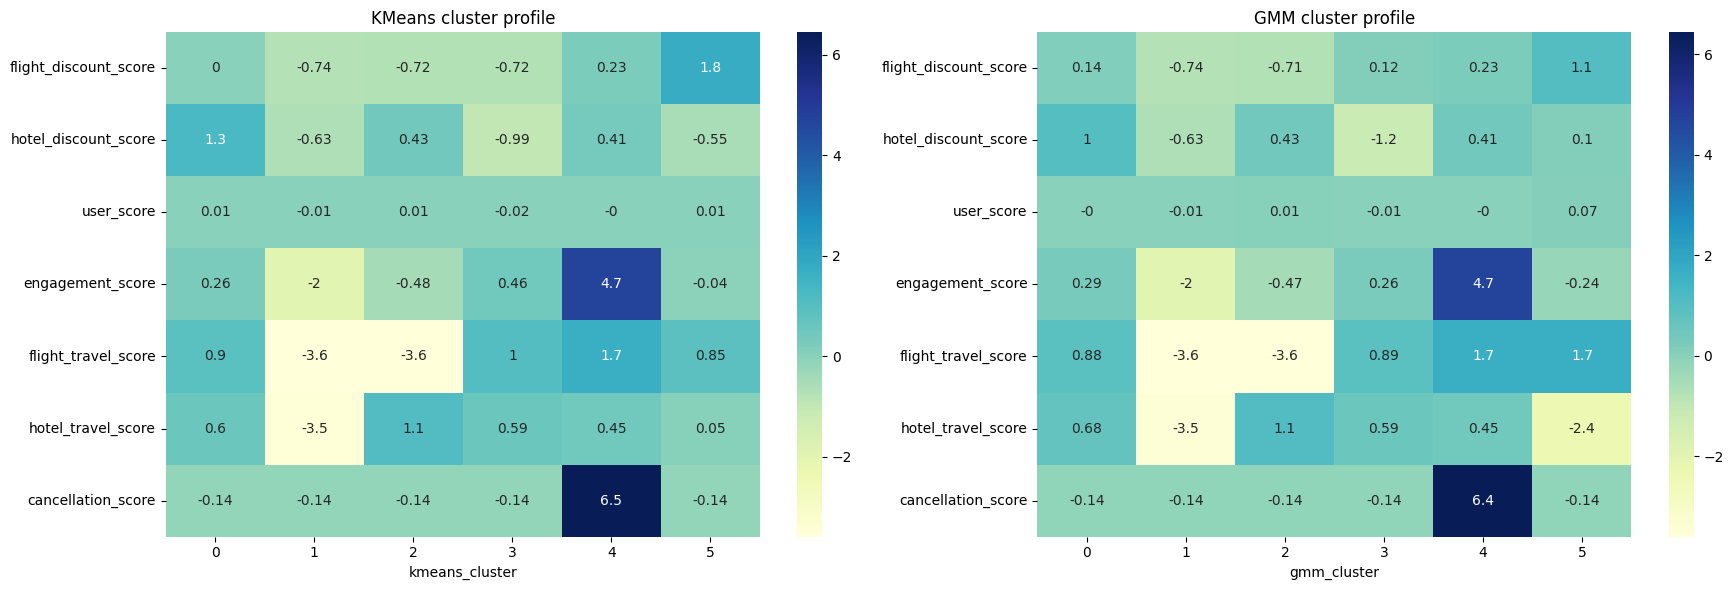

In [52]:
profiles_kmeans = cohort.groupby("kmeans_cluster")[scores].mean().round(2)
profiles_gmm = cohort.groupby("gmm_cluster")[scores].mean().round(2)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(profiles_kmeans.T, ax=axes[0], cmap="YlGnBu", annot=True)
axes[0].set_title("KMeans cluster profile")

sns.heatmap(profiles_gmm.T, ax=axes[1], cmap="YlGnBu", annot=True)
axes[1].set_title("GMM cluster profile")

plt.tight_layout()
plt.show()

### **Selecting cluster model**  
Kmeans performances slightly better than GMM regarding:  
davies_bouldin_score (lower value than GMM)  
calinski_harabasz_score (higher value than GMM)  
Also, mean score values are more discriminant in each cluster for the Kmeans model


**Labeling segments based on cluster results**

In [53]:
cluster_labels = {
    0: "Hotel Discount Hunter",
    1: "Churn-risk Users",
    2: "Frequent Hotel Traveller",
    3: "Frequent Flight Traveler",
    4: "Frequent Traveller with Cancellations",
    5: "Flight Discount Hunter",
}
cohort["customer_segments"] = cohort["kmeans_cluster"].map(cluster_labels)

**Compare feature mean values per segment**

In [ ]:
metrics = [
    m for k, metric in feature_groups.items() for m in metric if k != "user_score"
]
metrics.insert(0, "customer_segments")

cohort_grouped = cohort[metrics].groupby("customer_segments").mean().round(2).T

# create mapping
feature_to_group = {
    metric: group
    for group, metrics_list in feature_groups.items()
    for metric in metrics_list
}

# add MultiIndex
cohort_grouped.index = pd.MultiIndex.from_tuples(
    [
        (feature_to_group.get(metric, "Other"), metric)
        for metric in cohort_grouped.index
    ],
    names=["Feature Group", "Features"],
)

cohort_grouped.style.set_caption(
    "Average feature scores per Customer Segments"
).highlight_max(axis=1, color="lightblue").format("{:.2f}").set_properties(
    **{"font-size": "12px", "padding": "3px"}
).set_table_styles(
    [
        {"selector": "th", "props": [("text-align", "left")]},
        {
            "selector": "td",
            "props": [("max-width", "80px"), ("text-overflow", "ellipsis")],
        },
        {
            "selector": "th.row_heading",
            "props": [("font-weight", "bold"), ("font-size", "12px")],
        },
        {"selector": "th.col_heading", "props": [("font-size", "12px")]},
    ]
)

![segmentation table](../images/segmentation_table.png?v2)

**explore feature group importance**

In [55]:
# 1. X are grouped feature scores, y is target segment
X = cohort[scores]
y = cohort["kmeans_cluster"]

# 2. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=3)

# 3. Train model
rf = RandomForestClassifier(n_estimators=100, random_state=3)
rf.fit(X_train, y_train)

# 4. Permutation Importance
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=3, n_jobs=-1
)

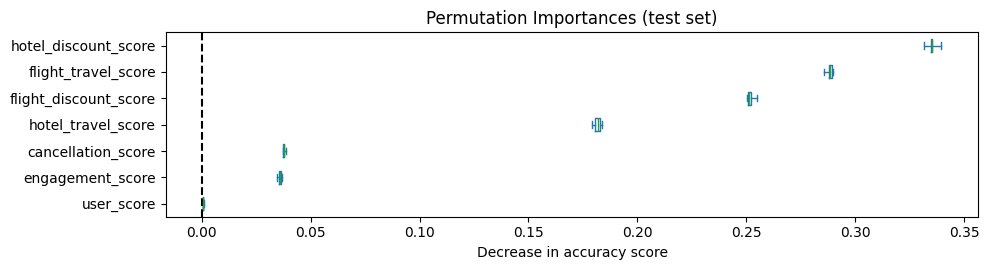

In [56]:
# 5. Visualization
sorted_idx = result.importances_mean.argsort()

importances = pd.DataFrame(
    result.importances[sorted_idx].T,
    columns=X.columns[sorted_idx],
)

fig, ax = plt.subplots(figsize=(10, len(sorted_idx) * 0.4))
importances.plot.box(vert=False, whis=50, ax=ax)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()

**Export cluster profiles**

In [57]:
float_values = cohort.select_dtypes(include=float).columns.to_list()
cohort[float_values] = cohort[float_values].round(2)

In [ ]:
file_io.read_or_write_csv(df=cohort, file_name="segmentation_results.csv")